# DBN Structure Inference

The idea is to infer a posterior for the *structure* of a Dynamic Bayesian Network (DBN), given some data.

We formulate this task with the following model:

$$ P(G | X) \propto P(X | G) \cdot P(G) $$

* $P(G)$ is a prior distribution over DBN structures. We'll assume it has the form
$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$
where $|G \setminus G^\prime|$ denotes the number of edges in the graph, which are not present in some reference graph $G^\prime$.
* $P(X | G)$ is the marginal likelihood of the DBN structure. That is, it's the likelihood of the DBN after the network parameters have been integrated out -- it scores network *structure*. 
* If we assume some reasonable priors for network parameters, $P(X|G)$ can be obtained in closed form. In this work, we'll use the following marginal likelihood:
    
    $$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$ 
    where $X$ and $B$ are matrices obtained from data; and $n$ is the total number of timesteps in the dataset. This marginal likelihood results from an empirical prior over the regression coefficients, and an improper ($\propto 1/\sigma^2$) prior for the regression "noise" variables.

## Get some data

For now, we'll work with some data used by Hill et al. in their 2012 paper, _Bayesian Inference of Signaling Network Topology in a Cancer Cell Line_.

It gives the differential phosphorylation levels of 20 proteins, in a cancer cell line perturbed by EGF. This is a well-studied signaling pathway; the goal is to produce a graph describing the dependencies between proteins in this pathway. 

NOTE: I have confirmed that the ordering of proteins in `protein_vec` is identical to the ordering in the columns of `timeseries_data`. So we can depend on that.

## Build the model

Implement the graph prior distribution:

$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$

Implement the DBN's marginal distribution:

$$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$

Some things to note:
* We're kind of shoe-horning this marginal likelihood into Gen. The probabilistic programming ethos entails modeling the entire data-generating process. This ought to provide better performance during inference, though.

A BUNCH OF HELPER FUNCTIONS:

THE MARGINAL LIKELIHOOD DISTRIBUTION

## Inference

### Metropolis-Hastings over directed graphs

Proposal distribution:

Involution function:

### Our inference program

# TESTING THE NEW MODEL

In [1]:
using Gen
using GLMNet
include("PSDiGraph.jl")
using .PSDiGraphs
include("dbn_preprocessing.jl")
include("dbn_models.jl")
include("dbn_proposals.jl")
include("dbn_inference.jl")
using PyPlot
using Profile
using ProfileView

In [2]:
timeseries_data_path = "data/mukherjee_data.csv"
protein_names_path = "data/protein_names.csv"
reference_adj_path = "data/prior_graph.csv"
timesteps_path = "data/time.csv"

"data/time.csv"

In [3]:
(timeseries_vec, protein_vec, ref_adj, timesteps) = hill_2012_preprocess(timeseries_data_path, 
                                                                         protein_names_path, 
                                                                         reference_adj_path, 
                                                                         timesteps_path);

In [4]:
Gen.load_generated_functions()

In [5]:
clear_caches()
regression_deg = 4
phi_ratio = 1.0
lambda_prior_param = 0.25
n_samples = 100
fixed_lambda = 3.0
burnin = 10
thinning = 50
lambda_r = 0.5
median_degs = [1.0*sum(ps) for ps in ref_adj];

# edge_posterior, lambdas, lambda_accs, ps_accs = dbn_vertexwise_inference(ref_adj, 
#                                                                          timeseries_vec, 
#                                                                          regression_deg,
#                                                                          phi_ratio,
#                                                                          lambda_prior_param,
#                                                                          n_samples, 
#                                                                          burnin, 
#                                                                          thinning, 
#                                                                          lambda_r, 
#                                                                          median_degs,
#                                                                          fixed_lambda,
#                                                                          false)

edge_posterior, lambdas, lambda_accs, ps_accs = dbn_ps_swapping(ref_adj, 
                                                                timeseries_vec, 
                                                                regression_deg,
                                                                phi_ratio,
                                                                lambda_prior_param,
                                                                n_samples, 
                                                                burnin, 
                                                                thinning, 
                                                                lambda_r, 
                                                                median_degs,
                                                                fixed_lambda,
                                                                true)

([0.189 0.936 … 0.004 0.004; 0.187 0.991 … 0.006 0.007; … ; 0.251 0.125 … 0.348 0.004; 0.146 0.11 … 0.004 0.09], [2.810663014387422, 2.43288415156431, 2.444183498546064, 2.634002638744856, 2.700737943151952, 3.0034928391146387, 2.224590500633344, 2.4692407676073467, 2.2468936342012804, 2.7375689750629015  …  2.5780823515303903, 2.5492163383821564, 2.453495979749113, 2.4317273683821363, 2.581685589233353, 2.2061679998387453, 2.5136543237918922, 2.80064499233742, 2.7435732940992796, 2.3533701569241616], 0.4591732559303373, [0.031828645781203084, 0.029316384746271646, 0.03308978080272245, 0.021679511560404364, 0.03717345611049945, 0.024482033830447402, 0.04691222099889901, 0.03259933940546492, 0.039925933340006006, 0.010989890901811631, 0.029666700030027023, 0.042788509658692825, 0.019157241517365628, 0.0230407366629967, 0.023711340206185566, 0.032549294364928434, 0.038374537083375036, 0.026453808427584827, 0.054408968071264135, 0.04112701431288159])

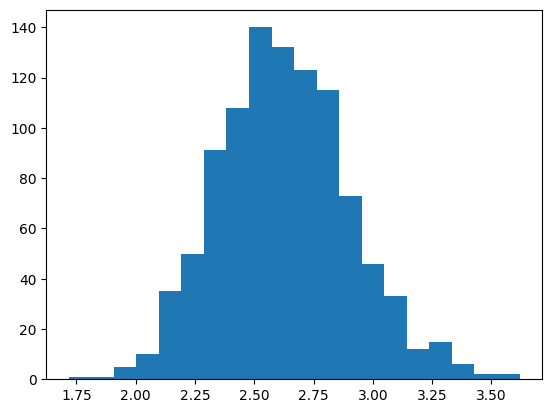

In [6]:
hist(lambdas, bins=20)
show()

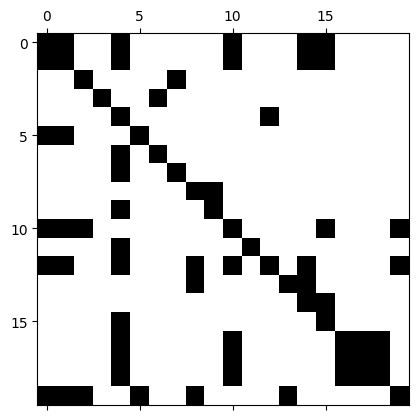

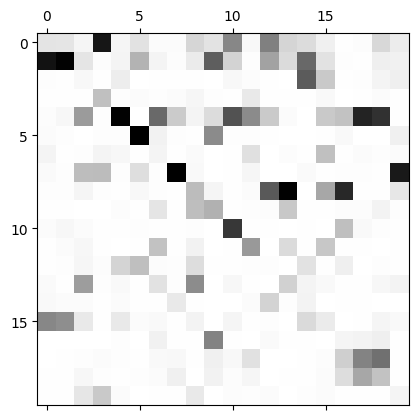

20-element Array{Float64,1}:
 0.08 
 0.087
 0.143
 0.019
 0.992
 0.012
 0.059
 0.013
 0.007
 0.023
 0.006
 0.003
 0.273
 0.048
 0.034
 0.164
 0.017
 0.019
 0.011
 0.034

In [11]:
matshow(transpose(ref_adj), cmap="Greys")
matshow(transpose(edge_posterior), cmap="Greys")
transpose(edge_posterior)[:,5]

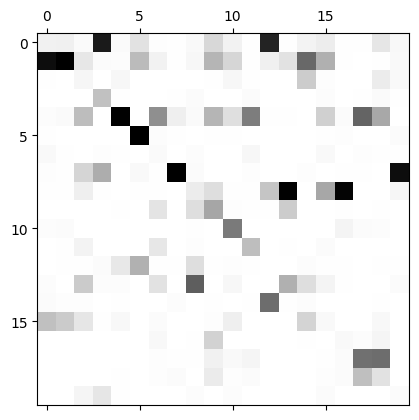

20-element Array{Float64,1}:
 0.04151771044803633  
 0.02618837309200779  
 0.06469924628671361  
 0.006317747411607069 
 0.994298928558952    
 0.0022928764635395346
 0.004484527186363329 
 0.0014488303810443158
 0.0018843036111529483
 0.006152936519921729 
 0.0012279665208409843
 0.0010992287856416972
 0.16707381579417158  
 0.01963621878837054  
 0.007468221996292591 
 0.056445509091101326 
 0.0038425029099626077
 0.003169592984620425 
 0.007622028367872339 
 0.0053734216081560305

In [13]:
hill_result = convert(Matrix{Float64}, CSV.read("data/edge_prob_matrix.csv"))
matshow(hill_result, cmap="Greys")
hill_result[:,5]

In [ ]:
hill_result[:,5]

In [ ]:
function phi_ratio_schedule(t::Float64)
    return 1.0 / (1.0 + exp(-30.0*(t - 0.5)))
end

In [ ]:
t = collect(0.0:0.01:1.0)
pr = [phi_ratio_schedule(t0) for t0 in t]
plot(t, pr)
show()

In [ ]:
clear_caches()
#Profile.clear()

#@profile edge_posterior, ps_accs = dbn_edgeind_annealing_inference(ref_adj, 
edge_posterior, ps_accs = dbn_edgeind_annealing_inference(ref_adj,
                                                          timeseries_vec, 
                                                          regression_deg,
                                                          phi_ratio_schedule,
                                                          fixed_lambda,
                                                          n_samples,
                                                          thinning,  
                                                          median_degs)

In [ ]:
transpose(edge_posterior)

In [ ]:
hill_result

In [ ]:
typeof(Gen.NoChange())

In [ ]:
clear_caches()

In [ ]:
ProfileView.view()

In [ ]:
clear_caches()
burnin = 20
thinning = 20
n_samples = 100
Profile.clear()
#@profile edge_posterior, edge_accs = dbn_edgeind_gibbs_inference(ref_adj, 
edge_posterior, edge_accs = dbn_edgeind_gibbs_inference(ref_adj,
                                                        timeseries_vec, 
                                                        regression_deg,
                                                        phi_ratio,
                                                        fixed_lambda,
                                                        n_samples,
                                                        burnin,
                                                        thinning)

In [ ]:
transpose(edge_posterior)

In [ ]:
hill_result

In [ ]:
ProfileView.view()

In [ ]:
[[3]; [true for i=1:10]]

In [ ]:
sum([true for i=1:10])

In [ ]:
using Pkg

In [ ]:
Pkg.add("FunctionalCollections")

In [ ]:
using FunctionalCollections

In [ ]:
v = PersistentVector{Float64}()

In [ ]:
y = convert(Vector{Float64}, v)

In [ ]:
v = PersistentVector{Float64}([1.0, 2.0, 3.0])

In [ ]:
y = Vector{Float64}([x for x in v])

In [ ]:
Bool(1)

In [ ]:
timeseries_vec

In [ ]:
t = convert(Matrix{Float64}, timesteps)
t = t[1,:]

In [ ]:
# for ts_array in timeseries_vec
#     plot(t, ts_array)
for ts_array in timeseries_vec
    plot(t, ts_array, linewidth=0.5)
end
xlim(5,240)
#yscale("log")
show()